# download packages

In [2]:
import warnings # tf needs to learn to stfu
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [3]:
# %pip install plotly

# Import the libraries

In [3]:
import numpy as np
import pandas as pd

# import io
import os
import tensorflow as tf

from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Dropout, Dense, MaxPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display
#To see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

ModuleNotFoundError: No module named 'plotly'

# prepare train test splits

In [ ]:
def prepare_for_train_test(X, Y):
    # Splitting into train and test set
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
    
    # With data augmentation to prevent overfitting


    train_datagen= ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        # randomly rotate images in the range (degrees, 0 to 180)
        rotation_range=10,
        zoom_range=0.1,  # Randomly zoom image
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False  # randomly flip images
    )
    train_datagen.fit(X_train)
    test_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen.fit(X_test)
    return X_train, X_test, Y_train, Y_test

# Prepare model

In [ ]:
def create_model():
    model = Sequential()
    model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2)))

    model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
    
    model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'))
    model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))

    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(7, activation='softmax'))

    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

    model.compile(loss = 'sparse_categorical_crossentropy',
                    optimizer = optimizer,
                    metrics = ['accuracy'])
    print(model.summary())
    return model # return the model


# prepare the training plan

In [ ]:
def train_model(model, X_train, Y_train, EPOCHS=25):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, 
                           mode='auto')
                               #, restore_best_weights=True)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, 
                              verbose=1, mode='auto')
    
    history = model.fit(X_train,
                        Y_train,
                        validation_split=0.2,
                        batch_size = 64,
                        epochs = EPOCHS,
                        callbacks = [reduce_lr, early_stop])
    return history

# test the model

In [ ]:
def test_model(model, X_test, Y_test):
    model_acc = model.evaluate(X_test, Y_test, verbose=0)[1]
    print("Test Accuracy: {:.3f}%".format(model_acc * 100))
    y_true = np.array(Y_test)
    y_pred = model.predict(X_test)
    y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))
    clr = classification_report(y_true, y_pred, target_names=label_mapping.values())
    print(clr)
    
    sample_data = X_test[:15]
    plt.figure(figsize=(22, 12))
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(sample_data[i])
        plt.title(label_mapping[y_true[i][0]] + '|' + label_mapping[y_pred[i]])
        plt.axis("off")
    plt.show() 

# training curves plot

In [ ]:
def plot_model_training_curve(history):
    fig = make_subplots(rows=1, cols=2, subplot_titles=['Model Accuracy', 'Model Loss'])
    fig.add_trace(
        go.Scatter(
            y=history.history['accuracy'], 
            name='train_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_accuracy'], 
            name='val_acc'), 
        row=1, col=1)
    fig.add_trace(
        go.Scatter(
            y=history.history['loss'], 
            name='train_loss'), 
        row=1, col=2)
    fig.add_trace(
        go.Scatter(
            y=history.history['val_loss'], 
            name='val_loss'), 
        row=1, col=2)
    fig.show()

# multi class confusion matrix

In [ ]:
def create_confusion_matrix(model, x_test_normalized, y_test, cm_plot_labels, name):
    #Get the true and predicted labels
    y_predict_classes, y_true_classes = cal_true_pred_classes(model, x_test_normalized, y_test)

    #Compute the confusion matrix
    confusion_matrix_computed = confusion_matrix(y_true_classes, y_predict_classes)

    #Plot the confusion matrix
    plot_confusion_matrix(confusion_matrix_computed, cm_plot_labels, name) 

In [ ]:
def plot_confusion_matrix(cm, classes,
                          name,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
#     b, t = plt.ylim()
#     b += 0.5
#     t -= 0.5
#     plt.ylim(b, t)
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    fig = plt
    fig.savefig('C:\\Users\\Marwan Gamal\\Downloads\\Skin Cancer\\Photo\\' + name + '_confusion_matrix.png', dpi=300)

# read the data

In [ ]:
base_skin_dir = os.path.join('..', 'input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/", '*', '*.jpg'))}
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

In [1]:
data = pd.read_csv(os.path.join(base_skin_dir,"skin-cancer-mnist-ham10000/",'HAM10000_metadata.csv'))

# Creating New Columns for better readability

# data['path'] = data['image_id'].map(imageid_path_dict.get)
# data['cell_type'] = data['dx'].map(lesion_type_dict.get) 
# data['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes


NameError: name 'pd' is not defined

In [ ]:
# Now lets see the sample of tile_df to look on newly made columns
data.head()

In [ ]:
data.describe(exclude=[np.number])

In [ ]:
data.isnull().any().sum()

# Imputing the Null values and preparing the data

In [ ]:
# Handling null values
data['age'].fillna(value=int(data['age'].mean()), inplace=True)
# Converting dtype of age to int32
data['age'] = data['age'].astype('int32')

In [ ]:
# Adding cell_type and image_path columns
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['path'] = data['image_id'].map(imageid_path_dict.get)

In [ ]:
data.head()

In [ ]:
# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))

In [ ]:
data.head(5)

In [ ]:
# Displaying 2 images for each label
sample_data = data.groupby('dx').apply(lambda df: df.iloc[:2, [9, 7]])
plt.figure(figsize=(22, 32))
for i in range(14):
    plt.subplot(7, 5, i + 1)
    plt.imshow(np.squeeze(sample_data['image_pixel'][i]))
    img_label = sample_data['cell_type'][i]
    plt.title(img_label)
    plt.axis("off")
plt.show();

In [ ]:
data['label'] = data['dx'].map(reverse_label_mapping.get)

data = data.sort_values('label')
data = data.reset_index()

In [ ]:
counter = 0
frames = [data]
for i in [4,4,11,17,45,52]:
    counter+=1
    index = data[data['label'] == counter].index.values
    df_index = data.iloc[int(min(index)):int(max(index)+1)]
    df_index = df_index.append([df_index]*i, ignore_index = True)
    frames.append(df_index)
    

In [ ]:
len(frames)

In [ ]:
final_data = pd.concat(frames)

In [ ]:
print(data.shape)
print(final_data.shape)

In [ ]:
# ORIGINAL DATA
# Converting image pixel columnm into required format
X_orig = data['image_pixel'].to_numpy()
X_orig = np.stack(X_orig, axis=0)
Y_orig = np.array(data.iloc[:, -1:])
print(X_orig.shape)
print(Y_orig.shape)

In [ ]:
# AUGMENTED DATA
# Converting image pixel columnm into required format
X_aug = final_data['image_pixel'].to_numpy()
X_aug = np.stack(X_aug, axis=0)
Y_aug = np.array(final_data.iloc[:, -1:])
print(X_aug.shape)
print(Y_aug.shape)

In [47]:
# For Original Dataset
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = prepare_for_train_test(X_orig, Y_orig)

In [48]:
model =create_model()

In [49]:
X_train_aug, X_test_aug, Y_train_aug, Y_test_aug = prepare_for_train_test(X_aug, Y_aug)

In [50]:
model2_history = train_model(model, X_train_aug, Y_train_aug, 50)

In [51]:
model

# save model

In [68]:
model.save('Skin_Cancer.sav')

# save model weights

In [59]:
model.save_weights("Skin_Cancer_Weights.hdf5")

In [62]:
from IPython.display import FileLink
FileLink('./Skin_Cancer.hdf5')

In [63]:
plot_model_training_curve(model2_history)

In [64]:
test_model(model, X_test_orig, Y_test_orig)

In [65]:
data.head()
data.iloc[2]

In [66]:
'''單張圖片的預測1'''
one_picture_predict_data = data.iloc[2]
print(one_picture_predict_data)
print(one_picture_predict_data.dx)
#print(one_picture_predict_data.image_pixel)
y_value = reverse_label_mapping.get(one_picture_predict_data.dx)
print(y_value)


one_picture_predict_data.image_pixel.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

In [67]:
'''單張圖片的預測2'''
print(data.iloc[2].path)
im = np.asarray(Image.open(data.iloc[2].path))
im.shape
im = im.reshape((1,450,600,3))
im.shape
new_one = one_picture_predict_data.image_pixel.reshape((1,28,28,3))
model.predict(new_one)

# function load pre-trained model

In [2]:


def load_pre_trained_model (path):
 # check if the path exists before trying to load the model
 if os.path.exists(path):
  model = load_model(path)
  return model # return the model
 else:
  print("Model not found") 

## prediction

In [3]:
def predict_single_image(model,file_name,lab_map=None,img_path=None, url=None ,img_height = 28, img_width = 28):
  '''Prediction for batches of images '''
  score = 0

  if not lab_map:
    lab_map={
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'}
  else:
    assert isinstance(lab_map, dict), f"expected a dict of key:int and value:str" # check if the lab_map is a dict

  if not img_path and url:
    path = tf.keras.utils.get_file(file_name, origin=url) # download the image
    img = tf.keras.utils.load_img(path, target_size=(img_height, img_width)) # load the image
  elif not url and img_path:
    img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width)) # load the image
    
    # show the image
    # plt.imshow(img)
    # plt.show()

    # convert the image to a numpy array
    # img = tf.keras.preprocessing.image.img_to_array(img)
  
  else:
    print("Error enter either path or url")  
    return
  img_array = tf.keras.utils.img_to_array(img) # convert the image to a numpy array
  img_array = tf.expand_dims(img_array, 0) # Create a batch images to predict

  predictions = model.predict(img_array) # make the prediction
  score = tf.nn.softmax(predictions[0]) # use softmax to make the classfication 

  # predict_imgs_dict = {}
  # predict_imgs_dict['image_pixel'] = np.asarray(Image.open(imgPath).resize((28,28)))
  # print(predict_imgs_dict['image_pixel'].shape)    

  # one_picture_predict_data.image_pixel.shape
  # new_one = predict_imgs_dict['image_pixel'].reshape((1,28,28,3))
  # print(new_one.shape)
  
  # prediction = model.predict(new_one)
  print(
    "This is most likely to be {} with a {:.2f} percent confidence."
    .format(lab_map[np.argmax(score)], 100 * np.max(score))
  )
  label = lab_map[np.argmax(score)] 
  conf = 100 * np.max(score)
  return  label, conf



'Prediction for batches of images '


# predict the image using the restored model


1/1 [==============================] - 3s 3s/step
This is most likely to be nv with a 27.47 percent confidence.
27.47 confident the skin cancer lesion are is most likely  melanocytic nevi


Text(0.5, 1.0, 'Test image')

Text(0.5, 0, 'X pixel scaling')

Text(0, 0.5, 'Y pixels scaling')

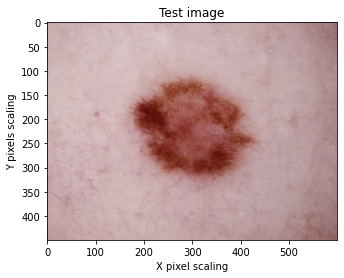

In [4]:

model = load_pre_trained_model()
image = "./ISIC2018_Task3_Test_Input/ISIC_0034558.jpg"

# get the image width and image height
img = Image.open(image)
width, height = img.size


label, confidence = predict_single_image(model=model,img_path=image,file_name="test")
if label == "mel": 
  class_name="melanoma"
elif label == "df":  
  class_name ="dermatofibroma"
elif label ==  "nv":
  class_name ="melanocytic nevi"
elif label ==  "akiec":
  class_name ="Actinic keratoses and intraepithelial carcinoma / Bowen's disease"
elif label ==  "bcc":
  class_name ="basal cell carcinoma"
elif label ==  "vasc":
  class_name ="vascular lesions"
elif label ==  "bkl":
  class_name ="benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses"
else:
  class_name ="unknown mostly no infection"  






print(f"{confidence:.2f} confident the skin cancer lesion are is most likely  {class_name}") 

plt.title("Test image")
plt.xlabel("X pixel scaling")
plt.ylabel("Y pixels scaling")
 
img = mpimg.imread(image)
plt.imshow(img)
plt.show()

In [6]:
# load csv file
def function_load_csv(file_name,start,end ):
  data = pd.read_csv(file_name)
  # read from position start to position end
  data = data.iloc[start:end]
  return data

In [7]:
function_load_csv("./ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv",1,10) 


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
1,ISIC_0034322,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0034323,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,ISIC_0034324,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0034325,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,ISIC_0034326,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,ISIC_0034328,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,ISIC_0034329,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,ISIC_0034330,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,ISIC_0034331,0.0,1.0,0.0,0.0,0.0,0.0,0.0
